## Kneser Ney Method for next word prediction

Kneser-Ney is a method primarily used to calculate the probability distribution of n-grams in a document based on their counts/histories in document.


#### Method


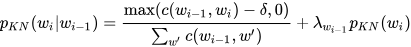




Where , `w` and `w'` are word followed by each other in corus.